In [ ]:
# import some necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.models import Model,Sequential
from keras.layers import Dense, Input, Dropout
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import confusion_matrix 

In [ ]:
# load the data
steel = pd.read_csv("Steel_industry_data (1).csv")
steel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  35040 non-null  object 
 1   Usage_kWh                             35040 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 4   CO2(tCO2)                             35040 non-null  float64
 5   Lagging_Current_Power_Factor          35040 non-null  float64
 6   Leading_Current_Power_Factor          35040 non-null  float64
 7   NSM                                   35040 non-null  int64  
 8   WeekStatus                            35040 non-null  object 
 9   Day_of_week                           35040 non-null  object 
 10  Load_Type                             35040 non-null  object 
dtypes: float64(6), 

In [ ]:
# need to change date, WeekStatus, Day_of_week, and Load_Type from object Dtype
steel['Load_Type'] = to_categorical(steel['Load_Type'].factorize()[0]) # This works, but le.fit_transform gives NaN for loss
le = LabelEncoder()
steel['date'] = le.fit_transform(steel['date'])
steel['WeekStatus'] = le.fit_transform(steel['WeekStatus'])
steel['Day_of_week'] = le.fit_transform(steel['Day_of_week'])
#steel['Load_Type'] = le.fit_transform(steel['Load_Type'])

In [ ]:
steel.info()
# now, all the data types are either float or int

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  35040 non-null  int64  
 1   Usage_kWh                             35040 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 4   CO2(tCO2)                             35040 non-null  float64
 5   Lagging_Current_Power_Factor          35040 non-null  float64
 6   Leading_Current_Power_Factor          35040 non-null  float64
 7   NSM                                   35040 non-null  int64  
 8   WeekStatus                            35040 non-null  int64  
 9   Day_of_week                           35040 non-null  int64  
 10  Load_Type                             35040 non-null  float32
dtypes: float32(1), 

<Axes: >

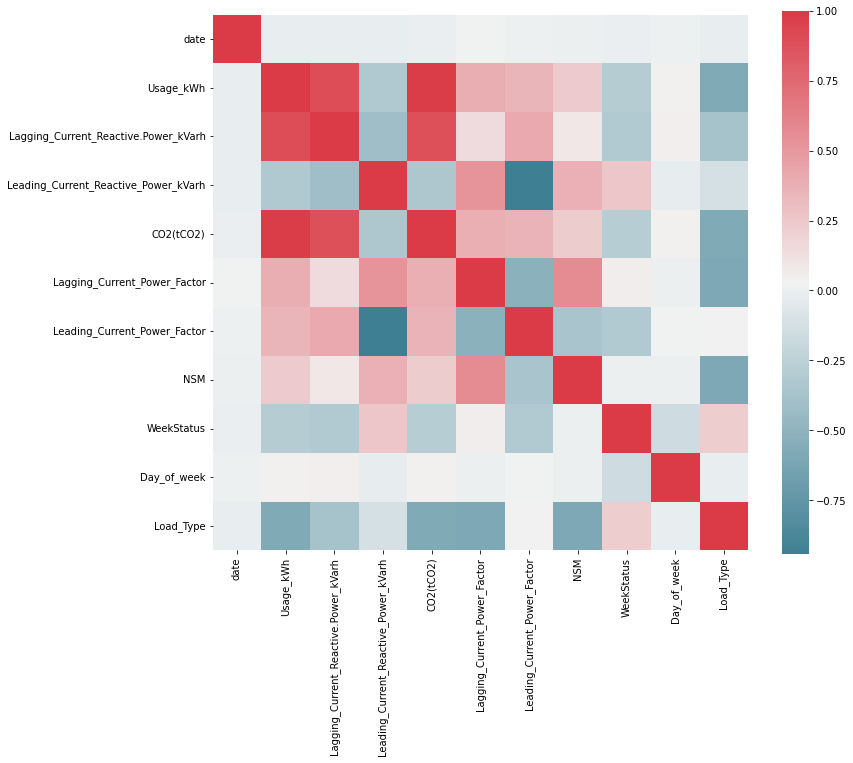

In [ ]:
# Create a correlation heatmap to see if any features are highly correlated
f, ax = plt.subplots(figsize = (12, 10))
corr = steel.corr()
sns.heatmap(corr, mask = np.zeros_like(corr, dtype = bool), cmap = sns.diverging_palette(220, 10, as_cmap = True), square = True, ax = ax)

Only a couple of these features are highly correlated. For an initial model, I will keep them all in place.

In [ ]:
# Split the data into X and Y
X = steel.drop(['Load_Type'], axis = 1)
Y = steel['Load_Type']

# Standardize the data
mm = MinMaxScaler()
fit = mm.fit(X)
X = fit.transform(X)

In [ ]:
# Split X and Y for testing and training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [ ]:
# Set up an initial model
model = Sequential()
model.add(Dense(16, activation = 'relu', input_shape = (10,)))
#model.add(Dropout(0.15))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(4, activation = 'relu'))
model.add(Dense(1, activation = 'relu'))

In [ ]:
# train the model
#opt = tf.keras.optimizers.SGD(learning_rate = 0.005)
model.compile(loss = 'mae', optimizer = 'sgd', metrics = ['accuracy'])
history = model.fit(X_train, Y_train, epochs = 20, batch_size = 64, verbose = 1, validation_data = (X_test, Y_test))

loss, acc = model.evaluate(X_test, Y_test, verbose = 0)
print('Test accuracy: %.3f' %acc)

loss, acc = model.evaluate(X_train, Y_train, verbose = 0)
print('Train accuracy: %.3f' %acc)

Epoch 1/20
438/438 [==============================] - 2s 3ms/step - loss: 0.4172 - accuracy: 0.5751 - val_loss: 0.2403 - val_accuracy: 0.8231
Epoch 2/20
438/438 [==============================] - 1s 3ms/step - loss: 0.1744 - accuracy: 0.8602 - val_loss: 0.1557 - val_accuracy: 0.8659
Epoch 3/20
438/438 [==============================] - 1s 3ms/step - loss: 0.1446 - accuracy: 0.8743 - val_loss: 0.1409 - val_accuracy: 0.8720
Epoch 4/20
438/438 [==============================] - 1s 3ms/step - loss: 0.1344 - accuracy: 0.8776 - val_loss: 0.1342 - val_accuracy: 0.8766
Epoch 5/20
438/438 [==============================] - 1s 3ms/step - loss: 0.1292 - accuracy: 0.8808 - val_loss: 0.1300 - val_accuracy: 0.8796
Epoch 6/20
438/438 [==============================] - 1s 3ms/step - loss: 0.1258 - accuracy: 0.8823 - val_loss: 0.1269 - val_accuracy: 0.8803
Epoch 7/20
438/438 [==============================] - 2s 4ms/step - loss: 0.1228 - accuracy: 0.8855 - val_loss: 0.1254 - val_accuracy: 0.8821
Epoch 

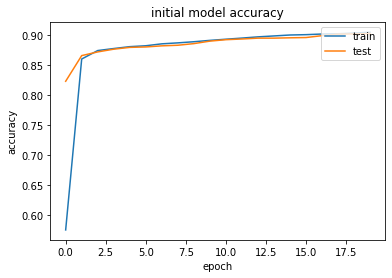

In [ ]:
# Plot the model accuracy over time
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('initial model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()

The accuracy of this model is pretty impressive at just over 90% across both testing and training. However, I'll attempt a second model and drop one of the highly correlated features (Lagging_Current_Reactive_Power_kVarh) and  to see if this has any bearing on the accuracy.

In [ ]:
# Split the data into X and Y, now dropping the only major highly correlated feature
X = steel.drop(['Load_Type', 'Lagging_Current_Reactive.Power_kVarh'], axis = 1)
Y = steel['Load_Type']

# Standardize the data
mm = MinMaxScaler()
fit = mm.fit(X)
X = fit.transform(X)

In [ ]:
# Split X and Y for testing and training
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)

In [ ]:
# Set up a second model
model = Sequential()
model.add(Dense(16, activation = 'relu', input_shape = (9,)))
#model.add(Dropout(0.15))
model.add(Dense(8, activation = 'relu'))
model.add(Dense(4, activation = 'relu'))
model.add(Dense(1, activation = 'relu'))

In [ ]:
# train the second model
#opt = tf.keras.optimizers.SGD(learning_rate = 0.005)
model.compile(loss = 'mae', optimizer = 'adam', metrics = ['accuracy'])
history = model.fit(X_train, Y_train, epochs = 20, batch_size = 64, verbose = 1, validation_data = (X_test, Y_test))

loss, acc = model.evaluate(X_test, Y_test, verbose = 0)
print('Test accuracy: %.3f' %acc)

loss, acc = model.evaluate(X_train, Y_train, verbose = 0)
print('Train accuracy: %.3f' %acc)

Epoch 1/20
438/438 [==============================] - 3s 3ms/step - loss: 0.2894 - accuracy: 0.7363 - val_loss: 0.1546 - val_accuracy: 0.8704
Epoch 2/20
438/438 [==============================] - 1s 3ms/step - loss: 0.1417 - accuracy: 0.8740 - val_loss: 0.1362 - val_accuracy: 0.8756
Epoch 3/20
438/438 [==============================] - 2s 3ms/step - loss: 0.1301 - accuracy: 0.8808 - val_loss: 0.1259 - val_accuracy: 0.8818
Epoch 4/20
438/438 [==============================] - 2s 4ms/step - loss: 0.1248 - accuracy: 0.8825 - val_loss: 0.1212 - val_accuracy: 0.8853
Epoch 5/20
438/438 [==============================] - 2s 5ms/step - loss: 0.1207 - accuracy: 0.8844 - val_loss: 0.1166 - val_accuracy: 0.8900
Epoch 6/20
438/438 [==============================] - 2s 4ms/step - loss: 0.1173 - accuracy: 0.8889 - val_loss: 0.1134 - val_accuracy: 0.8920
Epoch 7/20
438/438 [==============================] - 2s 4ms/step - loss: 0.1145 - accuracy: 0.8915 - val_loss: 0.1106 - val_accuracy: 0.8947
Epoch 

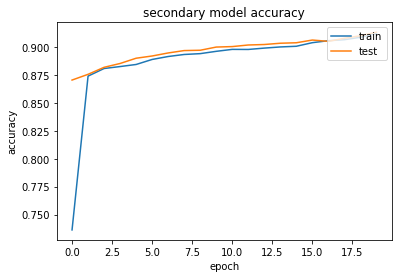

In [ ]:
# Plot the model accuracy over time
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('secondary model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()

After dropping the feature, the accuracy of this model is largely unchanged when compared to the previous one. As such, we can conclude that the Lagging_Current_Reactive.Power feature was not contributing significantly to the output.